# **Clustering Waveform Images**
This is the testing version of the clustering code. It assumes that you have a dataset with labels and allows you to look at the differences between the true waveform families and the clusters and see what clusters error waveforms are found in. Clustering.ipynb is the version that can be used without labels. 

## **The Dataset**
This code must be used with a dataset that follows a very specific format. An example called images_feb22small.zip can be found in this repository. Github does not allow for large files to be uploaded so it is a very small dataset with 25 families with 10 images each.

*   Images have names with labels in the the format: (5-digit familycode)(good/bad waveform)(date).png ex. **YYJ96H**good**0220025820.805883**.png  
*   Images are stored in a folder called "images".
*   This was created using Google Colab so by default the folder is found in the directory "content".
*   The full path of an example image is content/images/OCREJ5good0220025717.761071.png
*   All images are of size (1000, 1400) and have a white background 
*   [15:21] of the full image path contains the 5-digit family code and [21:24] contains the first 3 letters of the error label (goo/bad)

## **Editing the Code**
It is very likely that atleast one of the above assumptions will not be met and the code will need to be altered. For example, if the full path of the images is different, [15:21] may not be the location of the 5 digit code. 

#### **Different Folder Names, Image Names, or Full Path**
If folder names, images names, or the full path of the images stray from this example, the cell commented "Create dataset" will likely need to be edited. In this cell, the folder is opened so if the folders or full path is changed, that line will need to be edited. In addition, file[15:21] will likely not be the 5-digit family code. In the first line of the loop, both the family code and the error label are printed. If these are not correct, make sure to change them there and when they get appended to y and y_errors. a few lines below that. 

#### **Different Sized Images or Images Made with a Different Tool**
The images I used were made using matplotlib.pyplot but if a different tool was used or they are a different size, you will likely have to edit the cell commented "Create dataset". Near the end of the cell under the comment "cropping out axes", there is code to crop out the axes. You can uncomment the lines below to show the image to ensure that none of the axis is visible. To edit the cropping, you can editi the line "img_binary = img_binary[200:800,200:1200] # [startx:endy,starty:starty]" In the preprocessing, images are edited to be black and white. This code is there to reduce variation between images with different colored lines. This code can be removed if all images have a green background and a white line, for example. 

#### **K-Means**
The code requires you to specify a range of possible k values (# of clusters) to test below.


In [1]:
# installs
!pip3 install img2vec_pytorch
!pip3 install Pillow
!pip3 install scikit-learn

In [2]:
# imports
import tensorflow as tf
from sklearn.cluster import KMeans
from skimage import io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import glob
import cv2
from PIL import Image
from img2vec_pytorch import Img2Vec

from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import torch

In [8]:
# unzip dataset
!unzip images_feb22small.zip

Archive:  images_feb22small.zip
   creating: content/images/
  inflating: content/images/N15FQ7good0222220212.233524.png  
  inflating: content/images/72R7K0bad0222220312.387282.png  
  inflating: content/images/JQ8D5Bbad0222220252.772927.png  
  inflating: content/images/KXPIILbad0222220155.207077.png  
  inflating: content/images/74BSQQgood0222220224.470817.png  
  inflating: content/images/J4KIUJgood0222220221.516067.png  
  inflating: content/images/74BSQQgood0222220226.243638.png  
  inflating: content/images/FDB8B8good0222220153.224376.png  
  inflating: content/images/1P55W6bad0222220238.223687.png  
  inflating: content/images/791XPSgood0222220242.146196.png  
  inflating: content/images/NE7H7Mbad0222220249.083335.png  
  inflating: content/images/JQ8D5Bgood0222220253.127844.png  
  inflating: content/images/0NZ9MZgood0222220217.447546.png  
  inflating: content/images/NE7H7Mgood0222220250.062410.png  
  inflating: content/images/SAZOU8bad0222220205.979730.png  
  inflating: co

In [4]:
# Initialize Img2Vec with GPU
img2vec = Img2Vec(cuda=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [27]:
# Create dataset
X = [] # image embeddings
X_imgs = [] # images
y = [] # family codes
y_errors = [] # error labels

# open images folder
path = "content/images/*.*"
for file in glob.glob(path):
  # print family code and error label
  print(file[15:21], file[21:24])

  # open image
  img = cv2.imread(file, 0)

  # make image binary
  ret, img_binary = cv2.threshold(img, 245, 255, cv2.THRESH_BINARY)
  if img_binary is not None:

    # family code 
    y.append(file[15:21])
    # error label
    y_errors.append(file[21:24])

    # cropping out axes  
    print(img_binary.shape)
    img_binary = img_binary[200:800,200:1200] # [startx:endy,starty:starty]
    #plt.imshow(img_binary, 'gray')
    #plt.show()
   
    # 3d
    stacked_img = np.stack([img_binary,]*3, axis=-1).astype(int)  
    #stacked_img*=255  

    # convert to PIL
    PIL_image = Image.fromarray(np.uint8(stacked_img)).convert('RGB')
    
    # Get an image embedding from img2vec, returned as a torch FloatTensor
    X.append(img2vec.get_vec(PIL_image, tensor=True))
    X_imgs.append(PIL_image)

NE7H7M goo
(1000, 1400)
791XPS bad
(1000, 1400)
24F0GG goo
(1000, 1400)
J4KIUJ goo
(1000, 1400)
BKKEG3 goo
(1000, 1400)
FDB8B8 goo
(1000, 1400)
P5FGE5 bad
(1000, 1400)
WT6S5F bad
(1000, 1400)
VZ38LI goo
(1000, 1400)
KXPIIL goo
(1000, 1400)
1P55W6 goo
(1000, 1400)
FDB8B8 bad
(1000, 1400)
VZ38LI goo
(1000, 1400)
0NZ9MZ bad
(1000, 1400)
JW7NHP goo
(1000, 1400)
BKKEG3 bad
(1000, 1400)
1P55W6 goo
(1000, 1400)
XQ9BCL goo
(1000, 1400)
J4KIUJ goo
(1000, 1400)
7C3TBJ goo
(1000, 1400)
0NZ9MZ goo
(1000, 1400)
S2I8BH goo
(1000, 1400)
24F0GG goo
(1000, 1400)
S2I8BH goo
(1000, 1400)
E113AZ bad
(1000, 1400)
1P55W6 bad
(1000, 1400)
N15FQ7 goo
(1000, 1400)
KXPIIL bad
(1000, 1400)
JQ8D5B bad
(1000, 1400)
72R7K0 bad
(1000, 1400)
WT6S5F goo
(1000, 1400)
J4KIUJ goo
(1000, 1400)
SAZOU8 bad
(1000, 1400)
0NZ9MZ bad
(1000, 1400)
J4KIUJ goo
(1000, 1400)
JW7NHP goo
(1000, 1400)
UEZAF6 bad
(1000, 1400)
SAZOU8 goo
(1000, 1400)
74BSQQ goo
(1000, 1400)
BKKEG3 goo
(1000, 1400)
FDB8B8 goo
(1000, 1400)
XQ9BCL goo
(1000

In [28]:
# convert torch tensors to numpy
X = np.array([t.squeeze().numpy() for t in X])

# check lengths of X and y
X.shape, len(y)

((250, 512), 250)

In [29]:
# test a range of k values (possible number of clusters) and print resulting silhouette scores
for k in range(20,30):
  kmeans_model = KMeans(n_clusters=k, init='k-means++', random_state=1)
  kmeans_model.fit(X)
  silhouette_score = metrics.silhouette_score(X, kmeans_model.labels_, metric='euclidean')
  print('k =', k, 'silhouette score:', silhouette_score)

k = 20 silhouette score: 0.1568409
k = 21 silhouette score: 0.15479973
k = 22 silhouette score: 0.1607512
k = 23 silhouette score: 0.16561289
k = 24 silhouette score: 0.1674881
k = 25 silhouette score: 0.1611828
k = 26 silhouette score: 0.15971573
k = 27 silhouette score: 0.16600567
k = 28 silhouette score: 0.17221259
k = 29 silhouette score: 0.17740099


In [30]:
# repeat a specific clustering
k = 25
kmeans_model = KMeans(n_clusters=k, init='k-means++', random_state=1)
kmeans_model.fit(X)
silhouette_score = metrics.silhouette_score(X, kmeans_model.labels_, metric='euclidean')
print('k =', k, 'silhouette score:', silhouette_score)

k = 25 silhouette score: 0.1611828


In [31]:
# table of the most common family in each cluster and the count of that family in that cluster
pd.set_option('display.max_rows', 95)
df = pd.DataFrame(kmeans_model.labels_, columns=['cluster labels'])
df['y'] = y
dfgb = df.groupby(df['cluster labels']).agg(mode=('y', lambda x: stats.mode(x)[0][0]),count=('y', lambda x: stats.mode(x)[1][0]))
dfgb.reset_index(inplace=True)
dfgb

,cluster labels,mode,count
0,0,WT6S5F,3
1,1,TVCGBY,9
2,2,72R7K0,3
3,3,S2I8BH,6
4,4,74BSQQ,6
5,5,1P55W6,4
6,6,JW7NHP,7
7,7,JQ8D5B,6
8,8,KXPIIL,5
9,9,SAZOU8,6


In [32]:
# calculate accuracy
count = 0
right = 0
for i, lab in enumerate(kmeans_model.labels_):
  count += 1
  if y[i] == list(dfgb[dfgb['cluster labels'] == lab]['mode'])[0]:
    right += 1

accuracy = right/count
accuracy

0.536

In [33]:
# get error proportions in clusters and overall
def get_error_proportions():
  error_dict = {}
  error_dict['all'] = [0,0]

  for i, lab in enumerate(kmeans_model.labels_):
    error_dict['all'][1] += 1
    if lab in error_dict:
      error_dict[lab][1] += 1
      # check if error label begins with 'b' 
      if y_errors[i][0] == 'b':
        error_dict[lab][0] += 1
        error_dict['all'][0] += 1
    else:
      error_dict[lab] = [0,1]
      # check if error label begins with 'b' 
      if y_errors[i][0] == 'b':
        error_dict[lab][0] += 1
        error_dict['all'][0] += 1

  for key in error_dict.keys():
    print('cluster', key, 'error rate:', error_dict[key][0]/error_dict[key][1], 'count:', error_dict[key][1])

get_error_proportions()

cluster all error rate: 0.416 count: 250
cluster 24 error rate: 0.1 count: 10
cluster 19 error rate: 0.8333333333333334 count: 12
cluster 21 error rate: 0.25 count: 8
cluster 14 error rate: 0.1 count: 10
cluster 18 error rate: 0.14285714285714285 count: 7
cluster 23 error rate: 0.3333333333333333 count: 6
cluster 2 error rate: 0.5 count: 6
cluster 12 error rate: 0.23076923076923078 count: 13
cluster 17 error rate: 0.23076923076923078 count: 13
cluster 8 error rate: 0.3 count: 10
cluster 6 error rate: 0.5714285714285714 count: 14
cluster 20 error rate: 1.0 count: 8
cluster 4 error rate: 0.2777777777777778 count: 18
cluster 22 error rate: 0.3333333333333333 count: 18
cluster 16 error rate: 0.3333333333333333 count: 9
cluster 3 error rate: 0.3076923076923077 count: 13
cluster 0 error rate: 1.0 count: 14
cluster 5 error rate: 1.0 count: 8
cluster 11 error rate: 0.25 count: 4
cluster 1 error rate: 0.23529411764705882 count: 17
cluster 9 error rate: 0.5454545454545454 count: 11
cluster 13 er

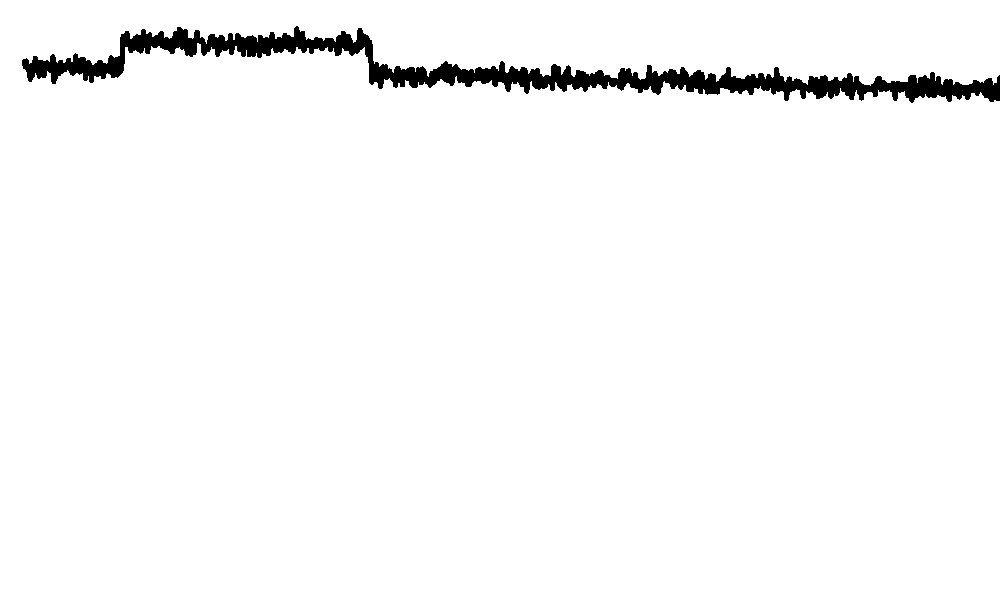

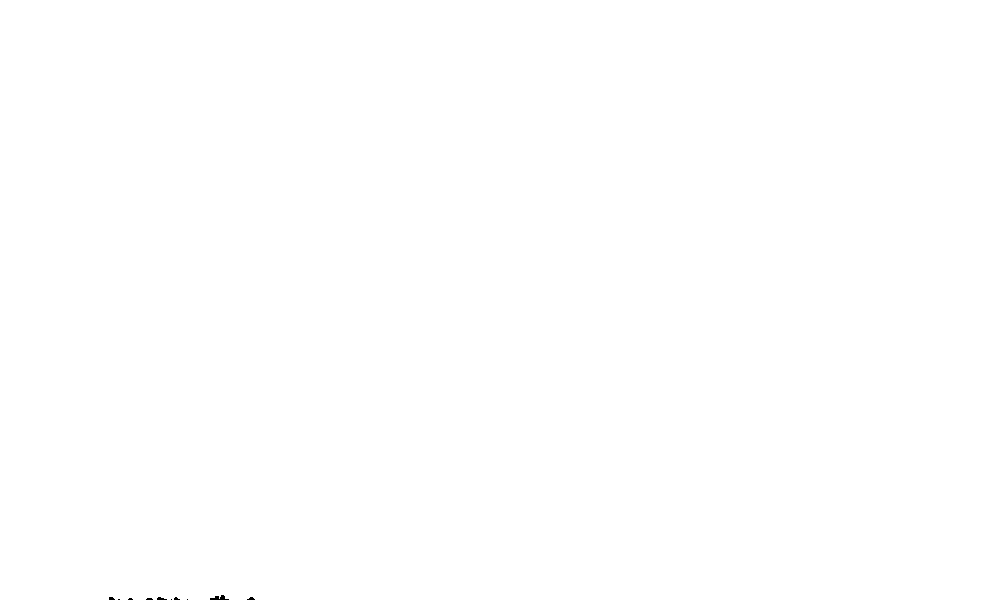

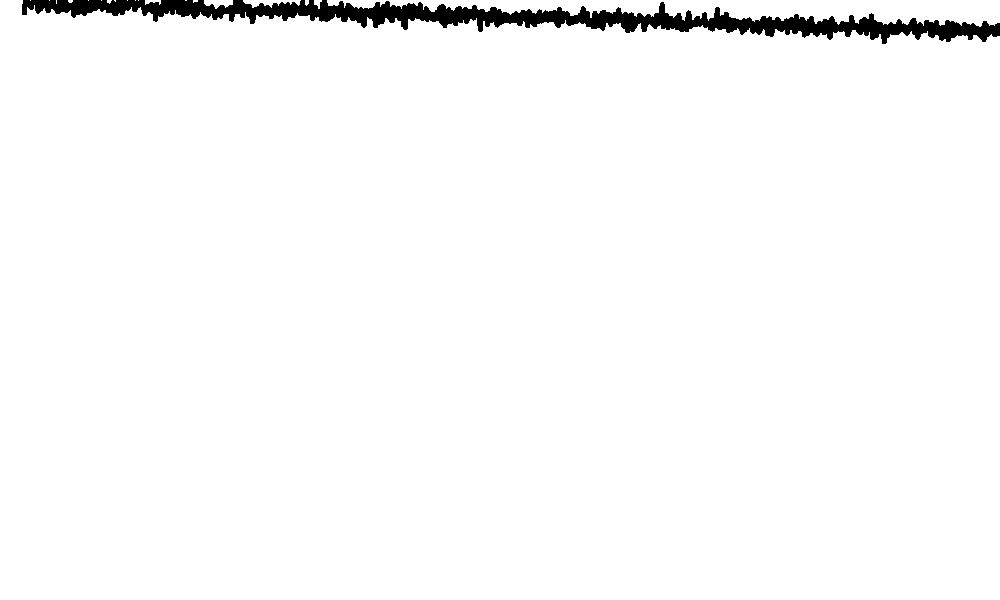

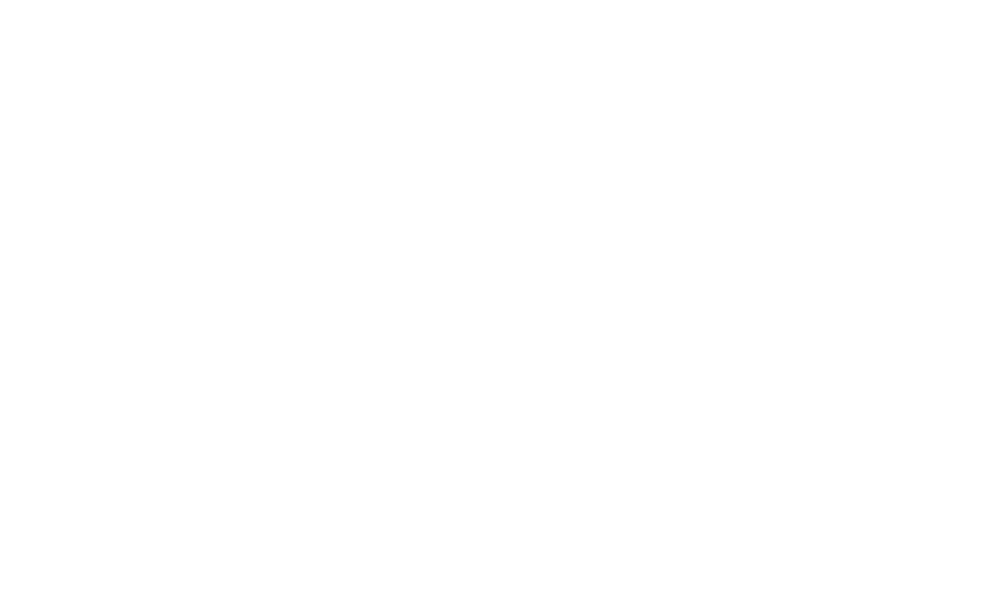

0.75

In [34]:
# show a given cluster's images and accuracy
def show_cluster(cluster):
  count = 0
  right = 0
  for i, lab in enumerate(kmeans_model.labels_):
    if lab == cluster:
      display(X_imgs[i])
      count += 1
      if y[i] == list(dfgb[dfgb['cluster labels'] == lab]['mode'])[0]:
        right += 1
  accuracy = right/count
  return accuracy
     
show_cluster(10)

In [ ]:
# prints clusters with an error rate over rate
def get_error_clusters(rate=.5):
  error_dict = {}
  error_dict['all'] = [0,0]

  for i, lab in enumerate(kmeans_model.labels_):
    error_dict['all'][1] += 1
    if lab in error_dict:
      error_dict[lab][1] += 1
      # check if error label begins with 'b' 
      if y_errors[i][0] == 'b':
        error_dict[lab][0] += 1
        error_dict['all'][0] += 1
    else:
      error_dict[lab] = [0,1]
      # check if error label begins with 'b' 
      if y_errors[i][0] == 'b':
        error_dict[lab][0] += 1
        error_dict['all'][0] += 1

  for key in error_dict.keys():
    if error_dict[key][0]/error_dict[key][1] >= rate:
      print('cluster', key, 'error rate:', error_dict[key][0]/error_dict[key][1], 'count:', error_dict[key][1])
      show_cluster(key)

get_error_clusters(rate=1)